<a href="https://colab.research.google.com/github/ramanakshay/Optimal-Transport/blob/main/notebooks/sinkhorn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Entropic Regularisation of Optimal Transport

##Importing Libraries



In [1]:
!pip install pot  # Pip Installs Packages

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 664 kB 7.1 MB/s 


In [2]:
user = 'ramanakshay'
repo = 'Optimal-Transport'

url = f"git+https://github.com/{user}/{repo}.git"
!pip install --upgrade {url}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ramanakshay/Optimal-Transport.git to /tmp/pip-req-build-caqrgbv6
  Running command git clone -q https://github.com/ramanakshay/Optimal-Transport.git /tmp/pip-req-build-caqrgbv6
  Created wheel for utils: filename=utils-0.1.0-py3-none-any.whl size=2956 sha256=1e2811638ef037f7e44d42a8ebabf7416727a680ee11193b130407bcf8f4242e
  Stored in directory: /tmp/pip-ephem-wheel-cache-05lj_a_t/wheels/83/c1/b0/8b4aae55c1a6c852e5e98d2e522e0c76c069f92e4d3885455f
Successfully built utils


In [3]:
import numpy as np 

import matplotlib.pyplot as plt # plotting

import ot  # ot
import ot.plot
from prettytable import PrettyTable

import time # measure time
from numpy import random

In [4]:
from utils.plot import plot_matrix,plot_2d_map
from utils.dist import find_cost_matrix,find_cost_matrix_old

##Sinkhorn Algorithm

In [5]:
def sinkhorn(a,b,C,epsilon,n):
  u = np.ones(a.shape[0])
  K = np.exp(-C / C.max() / epsilon) #kernel
  
  for i in range(n):
    v = b / np.dot(K.T,u)
    u = a / np.dot(K,v)

  P = u.reshape((-1, 1)) * K * v.reshape((1, -1))
  return P

In [6]:
def auto_sinkhorn(a,b,C,epsilon,error):
  u = np.ones(a.shape[0])
  K = np.exp(-C / C.max() /epsilon) #kernel

  v = b / np.dot(K.T,u)
  u = a / np.dot(K,v)
  P = u.reshape((-1, 1)) * K * v.reshape((1, -1))

  while(np.any(abs(np.sum(P,axis = 1) - a) >= error) or np.any(abs(np.sum(P,axis = 0) - b) >= error)):
    v = b / np.dot(K.T,u)
    u = a / np.dot(K,v)
    P = u.reshape((-1, 1)) * K * v.reshape((1, -1))

  return P

##1D Probability Distributions


###Gaussian (Normal) Distribution

$$ \large f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}\left (  \frac{x-\mu}{\sigma}\right )^2} $$

where $\mu$ is the mean and $\sigma$ is the standard deviation of the distribution.

In [7]:
def gaussian_mix(n,mu,std,scale = None):
  assert len(mu) == len(std)
  if scale == None:
    scale = [1]*len(mu)
  x = np.arange(n, dtype = np.float64)
  h = 0
  for i in range(len(mu)):
    h += np.exp(-(x - mu[i]) ** 2 / (2 * std[i] ** 2))*scale[i]
  return h / h.sum()

In [8]:
# 1D Guassian
n = 200 # number of bins

a = gaussian_mix(n,[20,100],[10,30],[2,1])
b = gaussian_mix(n,[40,150],[20,10],[1.5,1])

x = np.array([[i,] for i in range(n)]) # defining the space

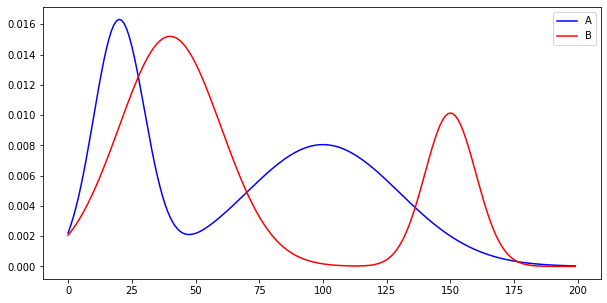

In [9]:
#Plot distributions
plt.figure(figsize=(10, 5))
plt.plot(x, a, 'b', label='A')
plt.plot(x, b, 'r', label='B')
plt.legend()
plt.show()

###Cost Matrix

###Cost Matrix Calculator

The cost matrix defines the cost of moving mass from $x_a$ to $x_b$. The $L_n$ metric is used as the distance metric.

$$ \large C_{i,j} = \left [ \left ( \sum^d_{k = 1}\left |  x_i(k)- y_j(k)\right |^n  \right )^ \frac {1}{n} \right ]^{p}$$

where $x_i$ is the position of $a_i$ \
and $y_j$ is the position of $b_j$



<Figure size 504x504 with 0 Axes>

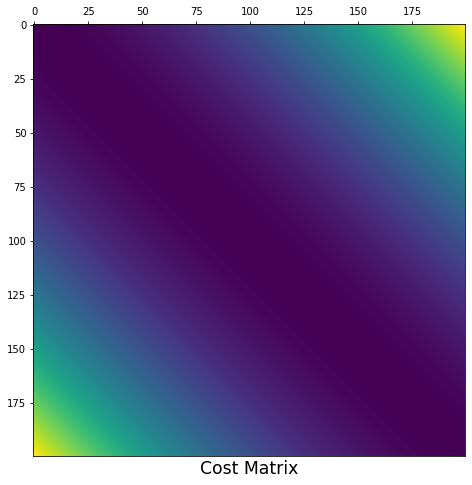

In [10]:
# Cost Matrix and Defining Distance
p = 2 # set p-value
C = find_cost_matrix(x,x,p,dist = ('ln_metric',2))

plt.figure(3, figsize=(7, 7))
plot_matrix(C,x,x,title = 'Cost Matrix')
plt.show()

###Optimal Coupling


P = argmax optimal coupling / optimal transport plan

Time Taken: 1.633s
Wasserstein Distance: 19.501


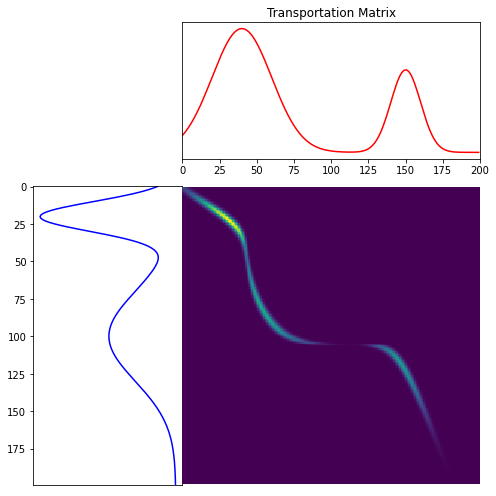

In [14]:
start = time.time()
# P = auto_sinkhorn(a, b, C, 1e-2, 1e-3)
P = ot.sinkhorn(a,b,C,10,numItermax = 10000,stopThr = 1e-6)
time_emd = time.time() - start

plt.figure(3, figsize=(7, 7))
ot.plot.plot1D_mat(a, b, P, 'Transportation Matrix')

print('Time Taken: ' + str(round(time_emd,3))+ 's')
W = pow(np.sum(C*P),1/p)
print('Wasserstein Distance:',round(W,3))

Time Taken: 0.019s
Wasserstein Distance: 19.38


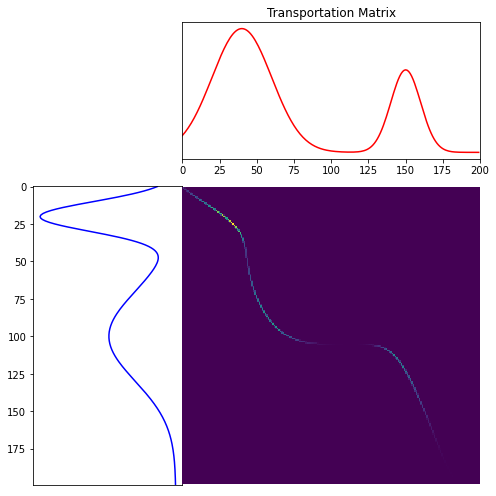

In [15]:
start = time.time()
P = ot.emd(a,b,C)
time_emd = time.time() - start

plt.figure(3, figsize=(7, 7))
ot.plot.plot1D_mat(a, b, P, 'Transportation Matrix')

print('Time Taken: ' + str(round(time_emd,3))+ 's')
W = pow(np.sum(C*P),1/p)
print('Wasserstein Distance:',round(W,3))

###Comparison

In [16]:
def quick_sinkhorn(a,b,xa,xb,epsilon,n,error = 1e-6):
  C = ot.dist(xa,xb)

  start = time.time()
  if (n == None):
    P = auto_sinkhorn(a,b,C,epsilon,error)
  else:
    P = sinkhorn(a,b,C,epsilon,n)
  time_emd = time.time() - start

  return P,pow(np.sum(C*P),0.5),time_emd

def quick_emd(a,b,xa,xb):
  C = ot.dist(xa,xb)

  start = time.time()
  P = ot.emd(a, b, C)
  time_emd = time.time() - start

  return P,pow(np.sum(C*P),0.5),time_emd

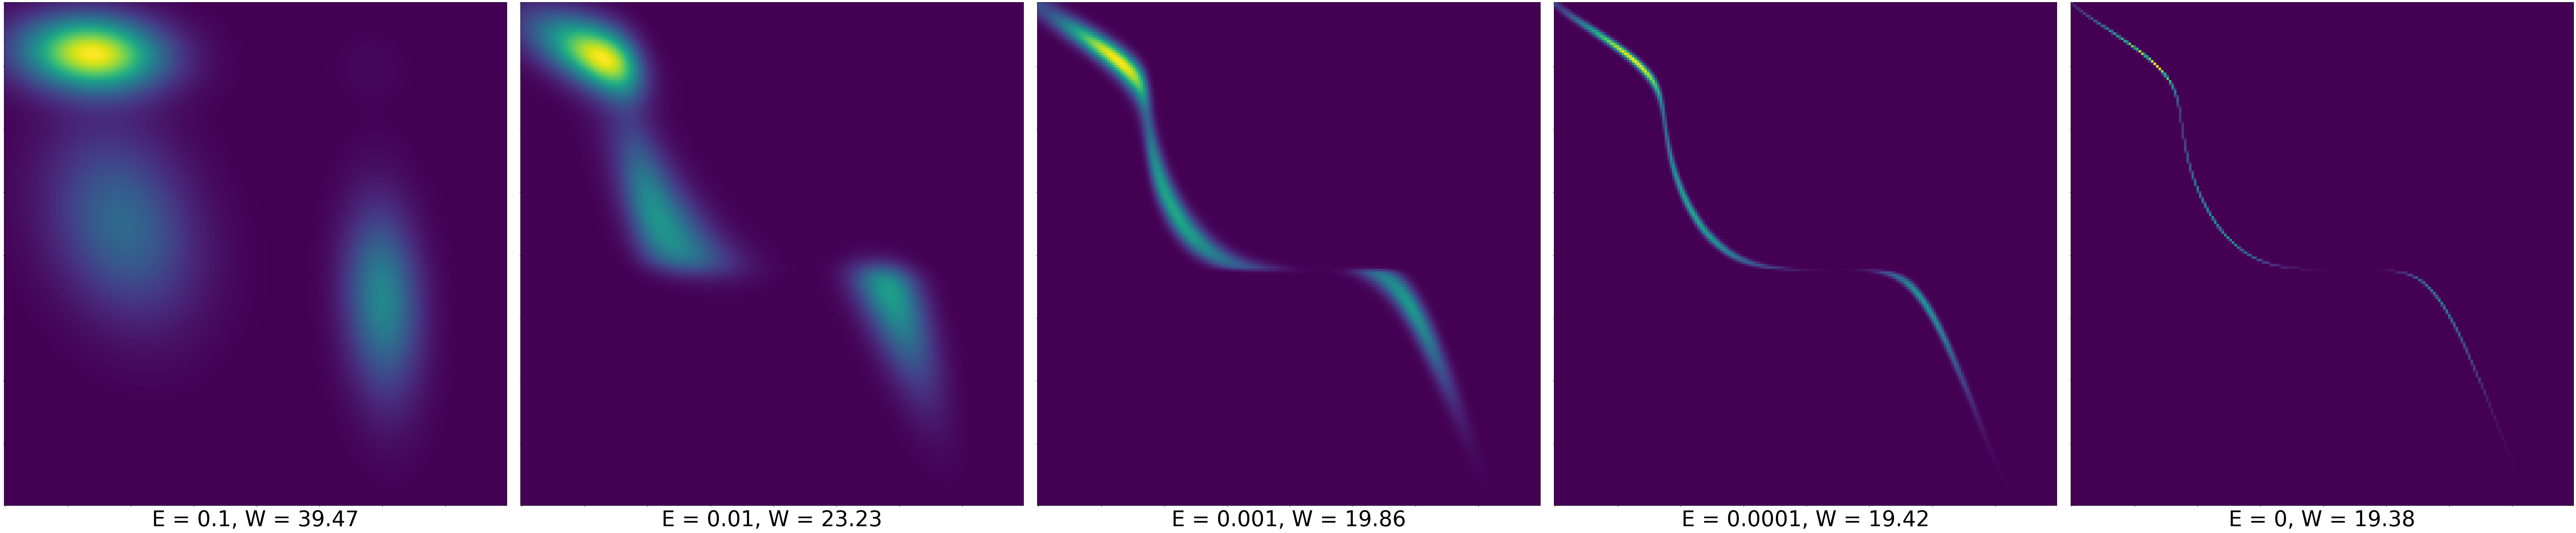

In [17]:
epsilon = 0.1
fig, axs = plt.subplots(1, 5, constrained_layout=True)
fig.set_figheight(100)
fig.set_figwidth(100)

i = 0
times = []
while(epsilon > 0.00001):
  P,W,t = quick_sinkhorn(a,b,x,x,epsilon,None,error = 1e-6)
  times.append([epsilon, round(t,3)])
  axs[i].imshow(P)
  axs[i].set_xlabel('E = ' + str(epsilon) + ", W = " + str(round(W,2)),size = 60)
  axs[i].set_xticklabels([])
  axs[i].set_yticklabels([])
  i += 1
  epsilon /= 10

P,W,t = quick_emd(a,b,x,x)
axs[i].imshow(P)
axs[i].set_xlabel('E = ' + str(0) + ", W = " + str(round(W,2)),size = 60)
axs[i].set_xticklabels([])
axs[i].set_yticklabels([])
plt.show()

In [18]:
table = PrettyTable()
table.field_names = ["Epsilon", "t (in seconds)"]
table.add_rows(times)
print(table)

+---------+----------------+
| Epsilon | t (in seconds) |
+---------+----------------+
|   0.1   |     0.014      |
|   0.01  |     0.076      |
|  0.001  |     0.332      |
|  0.0001 |     3.252      |
+---------+----------------+


In [19]:
## Running time for different values of n (n versus time)

table = PrettyTable()
table.field_names = ["N", "t(s), eps = 100","t(s), eps = 10","t(s), eps = 1","t(s), eps = 0.1","t(s), eps = 0.01"]

n = 10
while(n <= 10000):
  mu_a = 20*(n/10)
  std_a = 5*(n/10)
  a = ot.datasets.make_1D_gauss(n, mu_a, std_a)

  mu_b = 60*(n/10)
  std_b = 20*(n/10)
  b = ot.datasets.make_1D_gauss(n, mu_b, std_b)

  x = np.array([[i,] for i in range(n)]) # defining the space 
  
  epsilon = 100
  row = [n]
  while(epsilon >= 0.01):
    P,W,t = quick_sinkhorn(a,b,x,x,epsilon,None,1e-06)
    row.append(round(t,3))
    epsilon /= 10
  
  table.add_row(row)
  n *= 10

print(table)

+-------+-----------------+----------------+---------------+-----------------+------------------+
|   N   | t(s), eps = 100 | t(s), eps = 10 | t(s), eps = 1 | t(s), eps = 0.1 | t(s), eps = 0.01 |
+-------+-----------------+----------------+---------------+-----------------+------------------+
|   10  |       0.0       |      0.0       |      0.0      |      0.001      |      0.006       |
|  100  |      0.001      |     0.001      |     0.001     |      0.001      |      0.012       |
|  1000 |      0.044      |     0.044      |     0.047     |      0.092      |      0.611       |
| 10000 |       2.65      |      3.3       |     3.211     |      5.883      |      38.296      |
+-------+-----------------+----------------+---------------+-----------------+------------------+


##2D Discrete Points

In [20]:
n = 10  # nb samples

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([3, 3])
cov_t = np.array([[1, -.8], [-.8, 1]])

xa = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xb = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

a = np.ones(n) / n
b = np.ones(n) / n

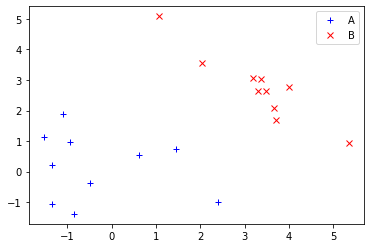

In [21]:
plt.figure(1)
plt.plot(xa[:, 0], xa[:, 1], '+b', label='A')
plt.plot(xb[:, 0], xb[:, 1], 'xr', label='B')
plt.legend(loc=0)
plt.show()

###Cost Matrix

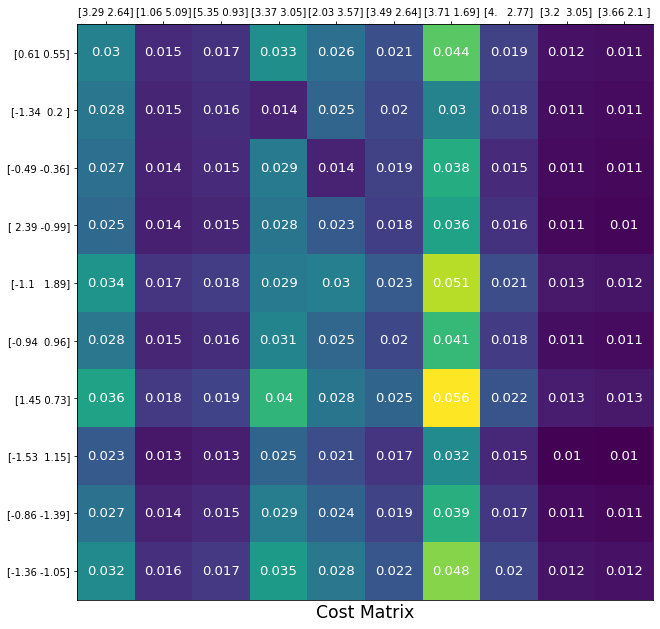

In [22]:
p = 2
C = find_cost_matrix(xa,xb,p,dist = ("coulomb",1))

plot_matrix(C,xa,xb,title = "Cost Matrix",size = (2.0,2.0))

###Sinkhorn

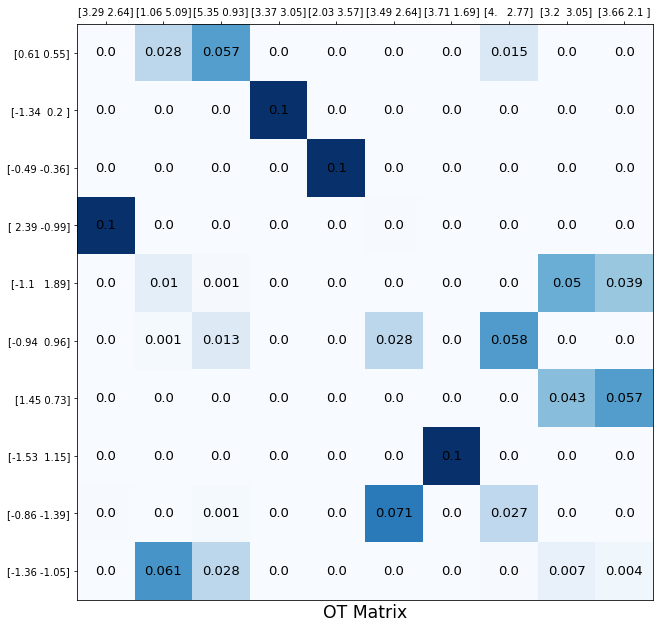

Time Taken: 5.333s
Wasserstein Distance 0.13452375113658294


In [23]:
start = time.time()
P = auto_sinkhorn(a,b,C,1e-3,1e-6)
time_emd = time.time() - start
plot_matrix(P,xa,xb,cmap = plt.cm.Blues,textcolor = 'black',title = 'OT Matrix',size = (2.0,2.0))
print('Time Taken: ' + str(round(time_emd,3))+ 's')
W = pow(np.sum(C*P),1/p)
print('Wasserstein Distance',W)

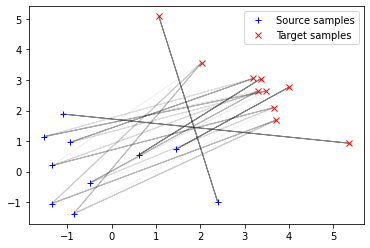

In [24]:
plt.figure(4)
plot_2d_map(xa,xb,P,limit = 0)
plt.show()

###EMD

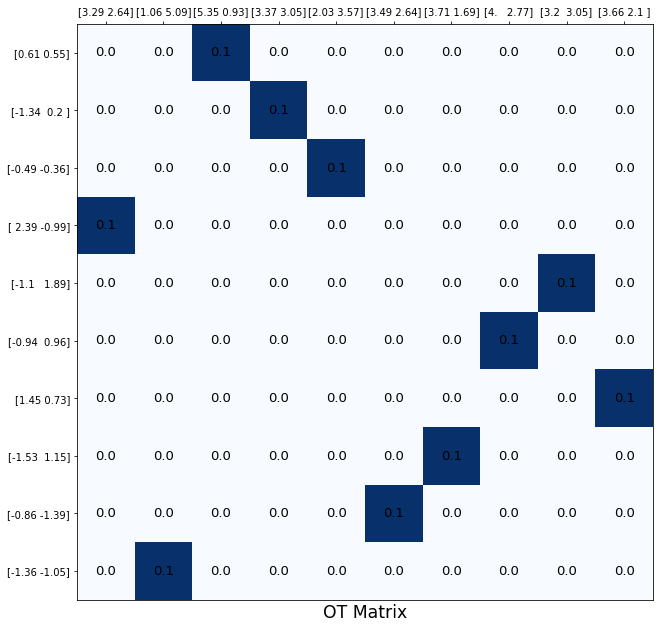

Time Taken: 0.001s
Wasserstein Distance 0.13447883002188254


In [25]:
start = time.time()
P = ot.emd(a,b,C)
time_emd = time.time() - start

plot_matrix(P,xa,xb,cmap = plt.cm.Blues,textcolor = 'black',title = 'OT Matrix',size = (2.0,2.0))
print('Time Taken: ' + str(round(time_emd,3))+ 's')
W = pow(np.sum(C*P),1/p)
print('Wasserstein Distance',W)

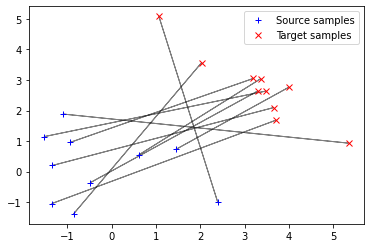

In [26]:
plt.figure(4)
plot_2d_map(xa,xb,P,limit = 0)
plt.show()

###Comparison

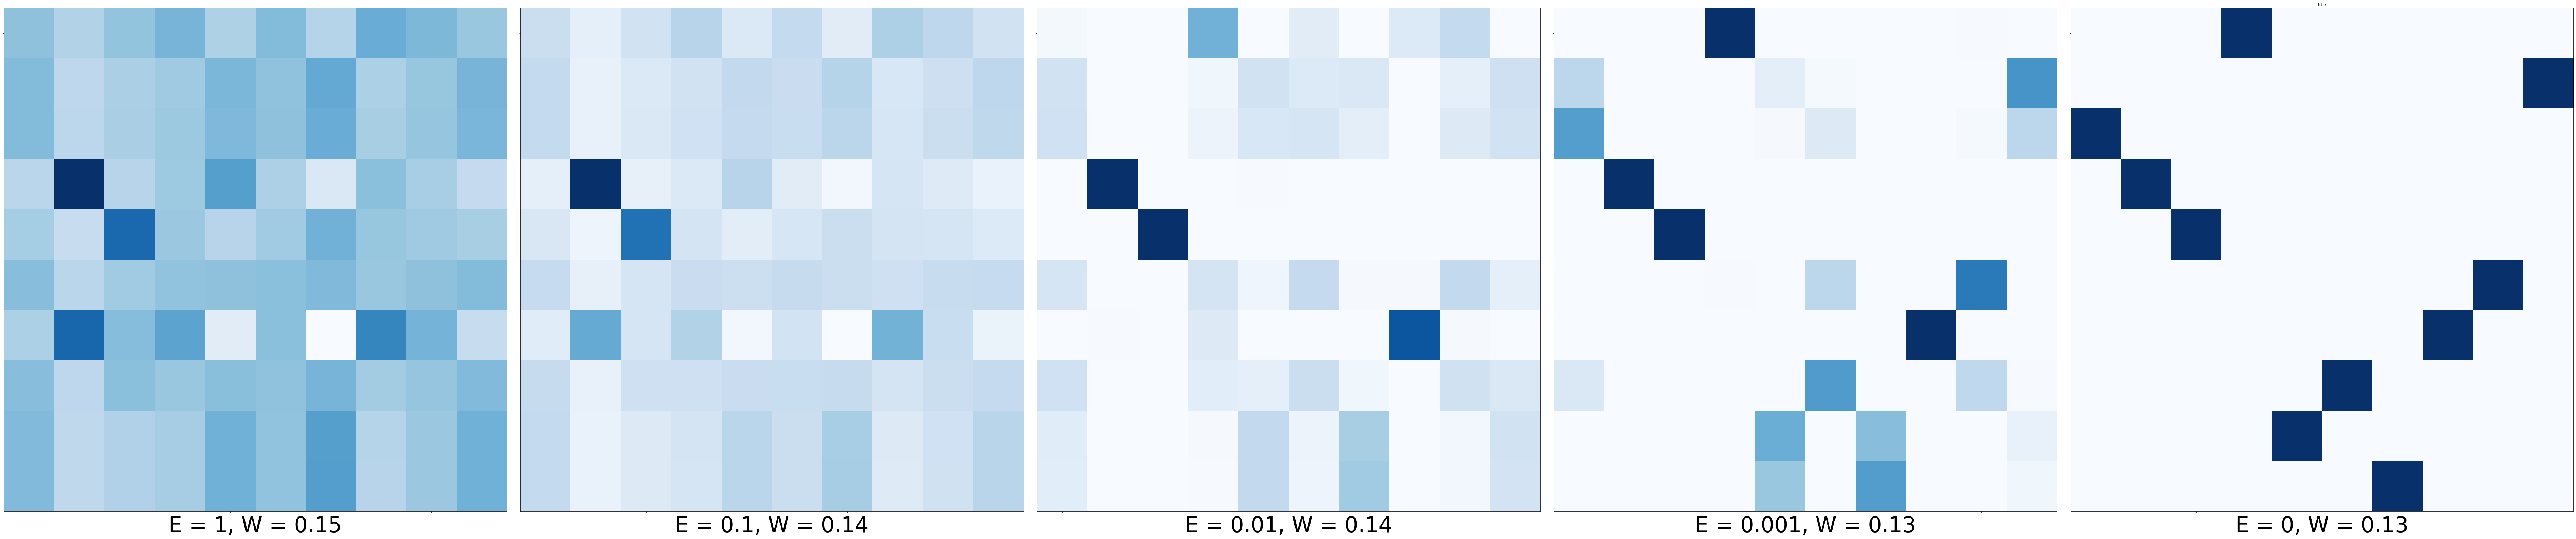

In [27]:
epsilon = 1
fig, axs = plt.subplots(1, 5,constrained_layout=True)
fig.set_figheight(100)
fig.set_figwidth(100)

plt.gca().set_title('title')
i = 0
while(epsilon >= 0.001):
  P = auto_sinkhorn(a, b, C,epsilon,1e-6)
  W = pow(np.sum(C*P),1/p)
  axs[i].imshow(P,cmap = plt.cm.Blues)
  axs[i].set_xlabel('E = ' + str(epsilon) + ", W = " + str(round(W,2)),size = 60)
  axs[i].set_xticklabels([])
  axs[i].set_yticklabels([])
  i += 1
  epsilon /= 10

P = ot.emd(a,b,C)
W = pow(np.sum(C*P),1/p)
axs[i].imshow(P,cmap = plt.cm.Blues)
axs[i].set_xlabel('E = ' + str(0) + ", W = " + str(round(W,2)),size = 60)
axs[i].set_xticklabels([])
axs[i].set_yticklabels([])
plt.show()

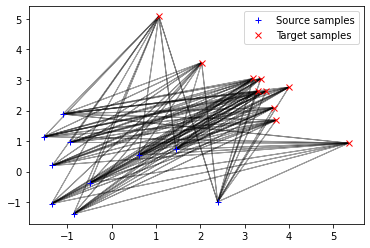

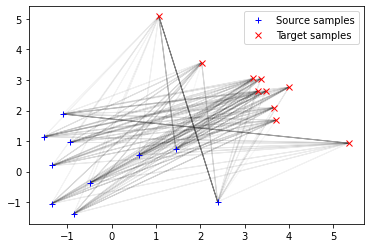

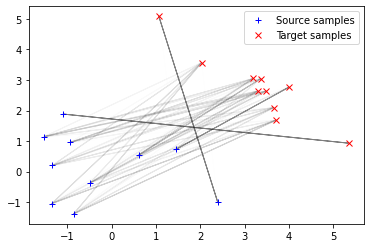

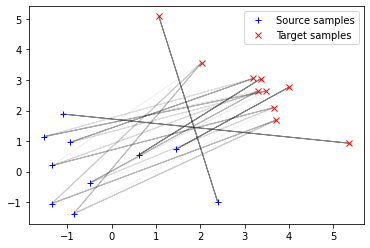

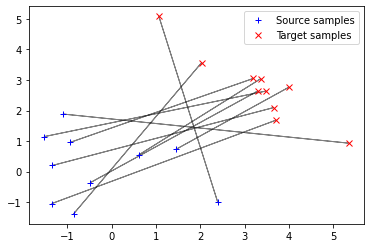

In [28]:
epsilon = 1
k = 1
while(epsilon >= 0.001):
  P = auto_sinkhorn(a, b, C,epsilon,1e-6)
  W = pow(np.sum(C*P),1/p)
  plt.figure(k)
  plot_2d_map(xa,xb,P,limit = 1e-5)
  plt.show()
  k += 1
  epsilon /= 10

P = ot.emd(a,b,C)
W = pow(np.sum(C*P),1/p)
plot_2d_map(xa,xb,P,limit = 0)